# Processing Luis' Simulation Data

In [229]:
import numpy as np 
import pickle
import matplotlib.pyplot as plt 
import pandas as pd 
from geopy.distance import geodesic as GD
from geopy.point import Point
import pymap3d as pm
from lstm import LSTM
from stable_baselines3.ppo import PPO
import torch
from parameters import pid_params
from tqdm import tqdm
from multirotor.controller import PIDController

In [221]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [328]:
data_load_try = []

with open("./data/luis_wind/e_shape_wind.pkl", "rb") as file:
    try:
        while True:
            data_load_try.append(pickle.load(file))
    except:
        print('done')

done


In [329]:
len(data_load_try)

589416

In [343]:
actions

array([[ 0.16320413, -0.06161255],
       [ 0.17604221, -0.06560796],
       [ 0.17614004, -0.06572432],
       ...,
       [-0.7080386 ,  0.16223256],
       [-0.7080386 ,  0.16223256],
       [-0.7378277 , -0.05511767]], dtype=float32)

In [330]:
df = pd.DataFrame(data_load_try)

In [331]:
next_wps = []
for wp in df['remaining_waypoints']:
    next_wps.append(wp[0])

In [332]:
df['next_wps'] = next_wps

In [333]:
df = df.drop('remaining_waypoints', axis=1)

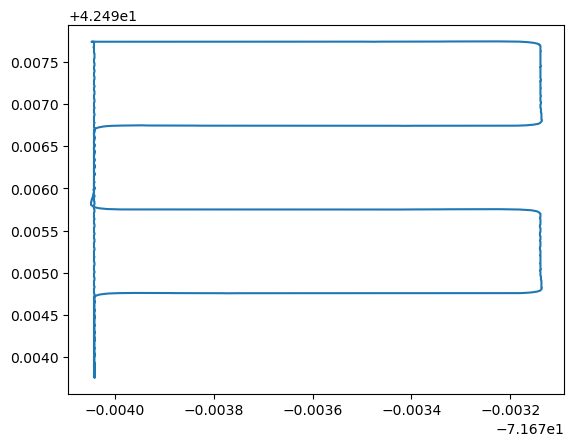

In [334]:
plt.plot(df['lon'].astype(float), df['lat'].astype(float))

In [179]:
df['next_wps'] = df['next_wps'].apply(tuple)

In [180]:
df = df.drop_duplicates()

In [181]:
df = df.reset_index(drop=True)

In [182]:
df.columns

Index(['lon', 'lat', 'ecefx', 'ecefy', 'ecefz', 'vEcefx', 'vEcefy', 'vEcefz',
       'alt', 'trackNumber', 'hdg', 'time_boot_ms', 'roll', 'pitch', 'yaw',
       'rollspeed', 'pitchspeed', 'yawspeed', 'next_wps'],
      dtype='object')

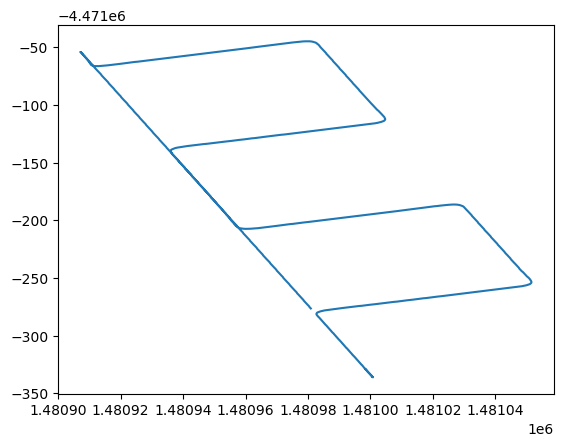

In [183]:
plt.plot(df['ecefx'].astype(float), df['ecefy'].astype(float))

In [184]:
tmp = pm.ecef2enu(df['ecefx'].astype(float), df['ecefy'].astype(float), df['ecefz'].astype(float), df['lat'].astype(float)[0], df['lon'].astype(float)[0], 0)

In [185]:
tmp = np.array(tmp).T

In [186]:
df['x'] = tmp[:,0]
df['y'] = tmp[:,1]

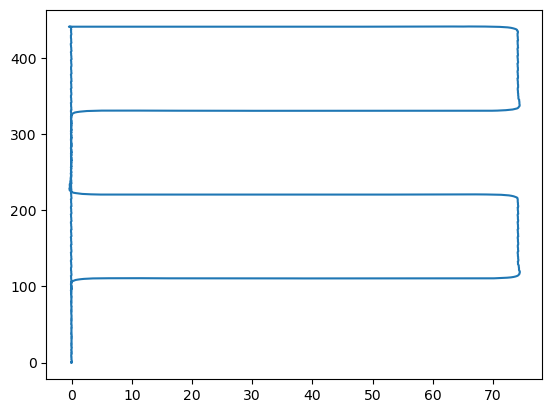

In [187]:
plt.plot(tmp[:,0], tmp[:,1])

In [188]:
tmp2 = pm.ecef2enuv(df['vEcefx'].astype(float), df['vEcefy'].astype(float), df['vEcefz'].astype(float), df['lat'].astype(float)[0], df['lon'].astype(float)[0], deg=True)

In [189]:
tmp2 = np.array(tmp2).T

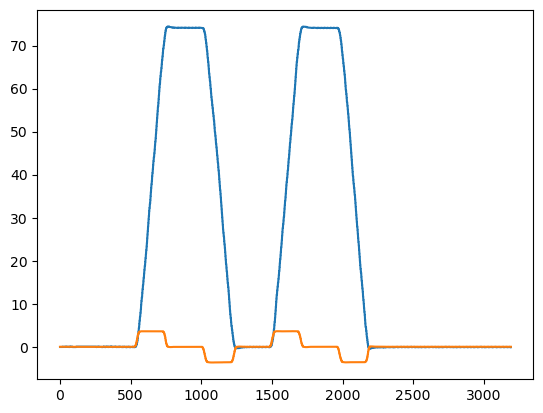

In [190]:
plt.plot(tmp[:,0])
plt.plot(tmp2[:,0])


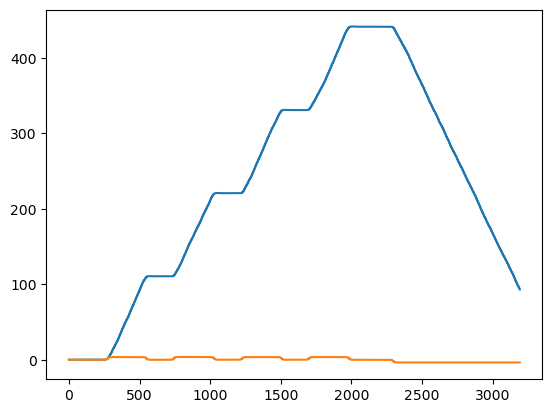

In [191]:
plt.plot(tmp[:,1])
plt.plot(tmp2[:,1])


In [192]:
tmp2[:,1]

array([ 0.00942156,  0.        ,  0.        , ..., -3.58977113,
       -3.58977113, -3.58977113])

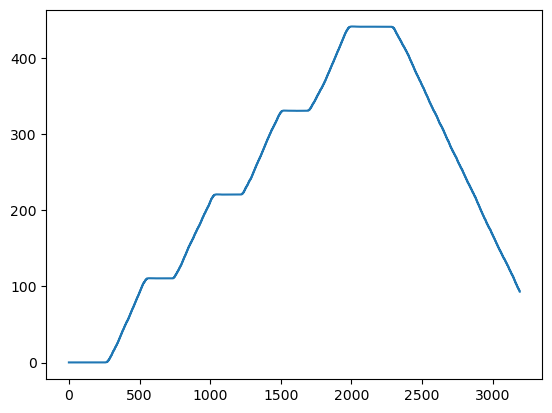

In [193]:
plt.plot(tmp[:,1])


In [194]:
df.columns

Index(['lon', 'lat', 'ecefx', 'ecefy', 'ecefz', 'vEcefx', 'vEcefy', 'vEcefz',
       'alt', 'trackNumber', 'hdg', 'time_boot_ms', 'roll', 'pitch', 'yaw',
       'rollspeed', 'pitchspeed', 'yawspeed', 'next_wps', 'x', 'y'],
      dtype='object')

In [195]:
wps = np.array(df['next_wps'].tolist())

xwp, ywp, zwp = pm.geodetic2enu(wps[:,0], wps[:,1], wps[:,2], df['lat'].astype(float)[0], df['lon'].astype(float)[0], 0)
df['xwp'] = xwp 
df['ywp'] = ywp 
df['zwp'] = wps[:,2] + 125 # seems off by a bit, temporary correction

In [196]:
pm.geodetic2enu(df['ecefx'].astype(float), df['ecefy'].astype(float), df['ecefz'].astype(float), df['lat'].astype(float)[0], df['lon'].astype(float)[0], 0)

(0      -6.726310e+06
 1      -6.726310e+06
 2      -6.726310e+06
 3      -6.726310e+06
 4      -6.726310e+06
             ...     
 3188   -3.428208e+05
 3189   -3.428208e+05
 3190   -3.923235e+05
 3191   -3.923235e+05
 3192   -4.518899e+05
 Length: 3193, dtype: float64,
 0      -8.086028e+06
 1      -8.086028e+06
 2      -8.086028e+06
 3      -8.086028e+06
 4      -8.086028e+06
             ...     
 3188   -1.039144e+07
 3189   -1.039144e+07
 3190   -1.039689e+07
 3191   -1.039689e+07
 3192   -1.040139e+07
 Length: 3193, dtype: float64,
 0      -7.967651e+06
 1      -7.967651e+06
 2      -7.967651e+06
 3      -7.967651e+06
 4      -7.967651e+06
             ...     
 3188   -8.570920e+06
 3189   -8.570920e+06
 3190   -8.536896e+06
 3191   -8.536896e+06
 3192   -8.503756e+06
 Length: 3193, dtype: float64)

In [197]:
df['next_wps']

0        (42.494757, -71.67404, 30.0, 1)
1        (42.494757, -71.67404, 30.0, 1)
2        (42.494757, -71.67404, 30.0, 1)
3        (42.494757, -71.67404, 30.0, 1)
4        (42.494757, -71.67404, 30.0, 1)
                      ...               
3188    (42.493763, -71.67404, 10.0, 10)
3189    (42.493763, -71.67404, 10.0, 10)
3190    (42.493763, -71.67404, 10.0, 10)
3191    (42.493763, -71.67404, 10.0, 10)
3192    (42.493763, -71.67404, 10.0, 10)
Name: next_wps, Length: 3193, dtype: object

In [198]:
df['x']

0      -0.050088
1      -0.050088
2      -0.050088
3      -0.050088
4      -0.050088
          ...   
3188   -0.126321
3189   -0.126321
3190   -0.093676
3191   -0.093676
3192   -0.092472
Name: x, Length: 3193, dtype: float64

In [199]:
def calc_intersection_d(df):
    print(len(df))
    intersection_distances = []
    lines = []
    points = []
    scales = []
    xwp = df['xwp']
    ywp = df['ywp']
    zwp = df['zwp']

    prev_wp = np.array([df['x'][0],df['y'][0],df['alt'].astype(float)[0]])

    for i, (x, y, z) in enumerate(zip(xwp, ywp, zwp)):
        curr_wp = np.array([x,y,z])
        curr_pos = np.array([df['x'].astype(float)[i], df['y'].astype(float)[i], df['alt'].astype(float)[i]])
        current_v = curr_pos - prev_wp
        des_unit_vec = (curr_wp - prev_wp) / np.linalg.norm(curr_wp - prev_wp)
        lines.append([curr_wp, prev_wp])

        scalar_factor = np.dot(current_v, des_unit_vec) / (np.dot(des_unit_vec, des_unit_vec)+1e-8)

        # Calculate the intersection point coordinates
        intersection_point = prev_wp + scalar_factor * des_unit_vec
        points.append(intersection_point)
        
        intersection_d = -(curr_pos - intersection_point)
        intersection_distances.append(intersection_d)
        if i+1 < len(xwp) and (xwp[i+1] != x or ywp[i+1] != y or zwp[i+1] != z):
            prev_wp = curr_wp.copy()
    

    return np.array(intersection_distances), np.array(lines), np.array(points)

In [200]:
ans, lines, points = calc_intersection_d(df)

3193


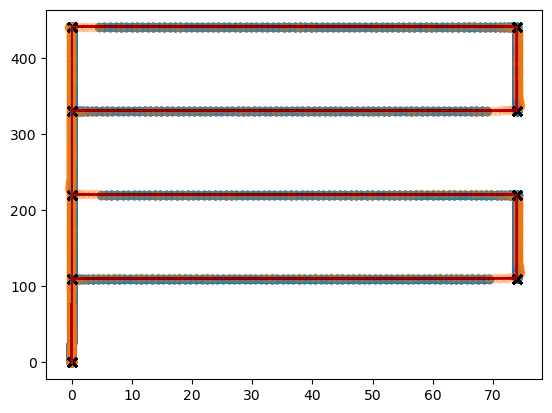

In [155]:
shown_points = range(len(points))
# shown_points = [500]

plt.scatter(points[shown_points,0], points[shown_points,1])
plt.scatter(df['x'][shown_points], df['y'][shown_points], alpha=0.1)
plt.scatter(df['xwp'][shown_points], df['ywp'][shown_points], marker='x', alpha=1, c='black')
for i in shown_points:
    plt.plot([df['x'][i], points[i, 0]], [df['y'][i], points[i, 1]], c='grey', alpha=0.1)
for i in shown_points:
    plt.plot([lines[i][0][0], lines[i][1][0]], [lines[i][0][1], lines[i][1][1]], c='red', alpha=0.01)

# plt.xlim(0,10)
# plt.ylim(100,125)

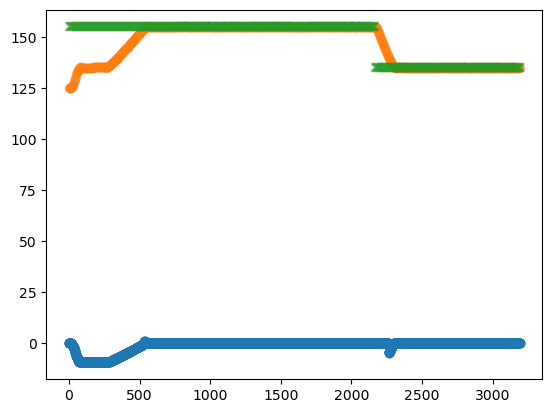

In [156]:
plt.scatter(range(len(points)), ans[:,2])
plt.scatter(range(len(points)), df['alt'].astype(float), alpha=0.1)
plt.scatter(range(len(points)), df['zwp'], marker='x', alpha=0.1)

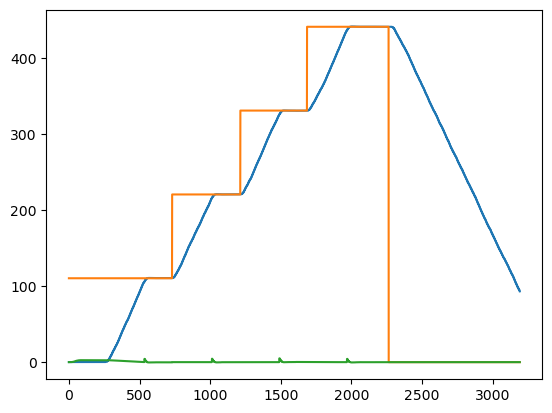

In [159]:
plt.plot(df['y'])
plt.plot(df['ywp'])
plt.plot(ans[:,1])

In [304]:
# Preprocess an entire file to be fed into our model
def process_file(filename):
    data_load_try = []

    with open(filename, "rb") as file:
        try:
            while True:
                data_load_try.append(pickle.load(file))
        except:
            pass 

    print(len(data_load_try))

    df = pd.DataFrame(data_load_try)
    next_wps = []
    for wp in df['remaining_waypoints']:
        next_wps.append(wp[0])

    df['next_wps'] = next_wps
    df = df.drop('remaining_waypoints', axis=1)
    xy_np = pm.ecef2enu(df['ecefx'].astype(float), df['ecefy'].astype(float), df['ecefz'].astype(float), df['lat'].astype(float)[0], df['lon'].astype(float)[0], 0)
    xy_np = np.array(xy_np).T
    df['x'] = xy_np[:,0]
    df['y'] = xy_np[:,1]
    df['next_wps'] = df['next_wps'].apply(tuple)
    df = df.drop_duplicates()
    df = df.reset_index(drop=True)
    
    wps = np.array(df['next_wps'].tolist())
    xwp, ywp, zwp = pm.geodetic2enu(wps[:,0], wps[:,1], wps[:,2], df['lat'].astype(float)[0], df['lon'].astype(float)[0], 0)
    df['xwp'] = xwp 
    df['ywp'] = ywp 
    df['zwp'] = wps[:,2] + 125 # seems off by a bit, temporary correction

    vxy_np = pm.ecef2enuv(df['vEcefx'].astype(float), df['vEcefy'].astype(float), df['vEcefz'].astype(float), df['lat'].astype(float)[0], df['lon'].astype(float)[0], deg=True)
    vxy_np = np.array(vxy_np).T
    df['vx'] = vxy_np[:,0]
    df['vy'] = vxy_np[:,1]
    df['vz'] = vxy_np[:,2]

    intersection_distances, _, _ = calc_intersection_d(df)
    df['err_str_x'] = intersection_distances[:,0]
    df['err_str_y'] = intersection_distances[:,1]
    df['err_str_z'] = intersection_distances[:,2]

    # X, Y, Z position error
    x_wp_err = df['x'] - df['xwp'] 
    y_wp_err = df['y'] - df['ywp'] 
    z_wp_err = df['alt'].astype(float) - df['zwp'] 
    
    # Velocities
    vx = df['vx']
    vy = df['vy']
    vz = df['vz']

    # Angles
    roll = df['roll'].astype(float)    
    pitch = df['pitch'].astype(float)
    yaw = df['yaw'].astype(float)

    # Rates
    rollrate = df['rollspeed'].astype(float)
    pitchrate = df['pitchspeed'].astype(float)
    yawrate = df['yawspeed'].astype(float)

    # Error to straight line between waypoints
    x_str_err = df['err_str_x']
    y_str_err = df['err_str_y']
    z_str_err = df['err_str_z']

    
    return np.vstack([x_wp_err, y_wp_err, z_wp_err, vx, vy, vz, roll, pitch, yaw, rollrate, pitchrate, yawrate, x_str_err, y_str_err, z_str_err]).T, np.vstack([df['x'], df['y'], df['alt'].astype(float)]).T

In [361]:
file_data, positions = process_file('./data/luis_wind/e_shape_no_wind.pkl')

560263
3193


In [344]:
def normalize_rl(state):
    state_range = np.zeros(17)
    state_range[0] = 500
    state_range[1] = 500
    state_range[2] = 100 
    state_range[3:6] = 2 * 15
    state_range[6:9] = 2 * np.deg2rad(22.5) * 2
    state_range[9:12] = 2 * np.deg2rad(22.5) * 2
    state_range[12:15] = state_range[:3]
    state_range[15:17] = 100 

    state = state * 2 / (state_range+1e-6) 
    return state

def normalize_lstm(lstm_input):
    normalization = np.array([1.5, 1.5, 1.5, 15, 15, 15, np.pi/12, np.pi/12, np.pi/12])

    return lstm_input / normalization

def load_rl():
    agent = PPO.load('./saved_models/higher_actions_noZ/96') 
    return agent

def load_lstm():
    lstm = LSTM(9, 64, 2, 3).to(device)
    lstm.load_state_dict(torch.load('./saved_models/lstm_disturbance_4hz.pth'))
    return lstm

def pos_controller(ref_pos, pos, pos_pid):
    ref_vel = pos_pid.step(ref_pos, pos, dt=0.25)
    return ref_vel

def calculate_safe_sliding_bound(reference_point, intersection_point, distance=5):
    # Convert points to numpy arrays for vector calculations
    reference_point = np.array(reference_point)
    intersection_point = np.array(intersection_point)
    
    # Calculate the vector from the point to the reference point
    vector_to_reference = reference_point - intersection_point
    
    # Calculate the distance between the point and the reference point
    distance_to_reference = np.linalg.norm(vector_to_reference)
    
    if distance_to_reference <= distance:
        # If the distance is within the specified range, return the reference point
        return reference_point
    else:
        # Calculate the intermediate point that is 'distance' units along the vector_to_reference
        intermediate_point = intersection_point + (distance / distance_to_reference) * vector_to_reference
        return intermediate_point

def vel_leash(ref_vel, eul, max_vel):
    The = eul[1]
    Phi = eul[0]
    Psi = eul[2]
    R_b_e = np.array([[np.cos(Psi)*np.cos(The), np.cos(Psi)*np.sin(The)*np.sin(Phi)-np.sin(Psi)*np.cos(Phi), np.cos(Psi)*np.sin(The)*np.cos(Phi)+np.sin(Psi)*np.sin(Phi)],
                  [np.sin(Psi)*np.cos(The), np.sin(Psi)*np.sin(The)*np.sin(Phi)+np.cos(Psi)*np.cos(Phi), np.sin(Psi)*np.sin(The)*np.cos(Phi)-np.cos(Psi)*np.sin(Phi)],
                  [-np.sin(The), np.cos(The)*np.sin(Phi), np.cos(The)*np.cos(Phi)]])
    
    velbody = R_b_e.T @ ref_vel
    velbody = velbody[0:2]

    norm = np.linalg.norm(velbody)
    if norm > max_vel:
        velbody = velbody * (max_vel / norm)

    velinert = np.linalg.pinv(R_b_e.T) @ np.array([velbody[0], velbody[1], 0])

    return velinert

def get_ref_vel(pos, str_err, wp_err, eul, pos_pid):
    max_vel = 15
    intersection_point = pos - str_err # might need to be subtraction
    next_waypt = pos - wp_err
    ref_pos = calculate_safe_sliding_bound(next_waypt, intersection_point, distance=23)
    inert_ref_vel = pos_controller(ref_pos, pos, pos_pid)
    inert_ref_vel = np.clip(inert_ref_vel, -max_vel, max_vel)
    inert_ref_vel_leashed = vel_leash(inert_ref_vel, eul, max_vel)
    inert_ref_vel_leashed = inert_ref_vel_leashed

    return np.array([inert_ref_vel_leashed[0], inert_ref_vel_leashed[1], inert_ref_vel[2]])

def get_control_actions(lstm, rl_agent, file_data, positions):
    actions = []
    ref_vels = []
    lstm_input = [np.zeros(9)] * 5
    max_vel = 15
    pid_parameters = pid_params()
    pos_pid = PIDController(k_p=pid_parameters.pos_p, k_i=pid_parameters.pos_i, k_d=pid_parameters.pos_d, max_err_i=0)

    prev_pos = file_data[0,:3]
    disturbance_pred = np.zeros(2)
    for i, row in tqdm(enumerate(file_data)):
        # First, compute the reference velocity
        pos = positions[i]
        ref_vel = get_ref_vel(pos, row[12:15], row[0:3], row[6:9], pos_pid)

        # Then, record the LSTM input
        curr_lstm_input = normalize_lstm(np.concatenate([(row[:3] - prev_pos),row[3:9]]))
        prev_pos = row[:3]
        lstm_input.append(curr_lstm_input)
        lstm_input.pop(0)

        # Only make a control action every 0.5 seconds
        if i % 2 == 0:
            disturbance_pred = lstm(torch.Tensor(np.array(lstm_input)).unsqueeze(0).to(device)).cpu().detach().numpy()[0]
            rl_state = np.concatenate([row[0:15],  disturbance_pred[0:2]], dtype=np.float32)
            rl_state = normalize_rl(rl_state)
            action = rl_agent.predict(rl_state, deterministic=True)[0]
            
        actions.append(action)
        ref_vels.append(ref_vel)

    return np.array(actions), np.array(ref_vels)

In [362]:
lstm = load_lstm()
rl_agent = load_rl()
actions, ref_vels = get_control_actions(lstm, rl_agent, file_data, positions)

213it [00:00, 2117.66it/s]

3193it [00:01, 2160.19it/s]


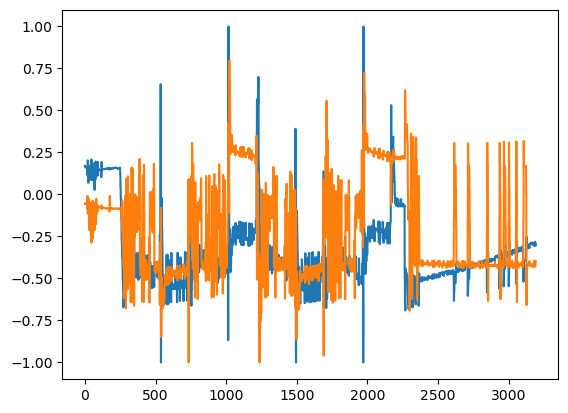

In [363]:
plt.plot(actions[:,0])
plt.plot(actions[:,1])

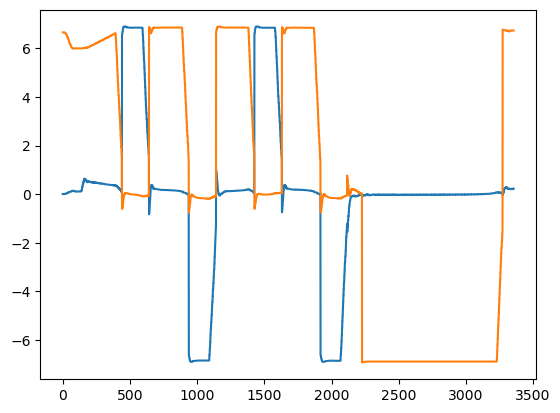

In [327]:
plt.plot(ref_vels[:,0])
plt.plot(ref_vels[:,1])

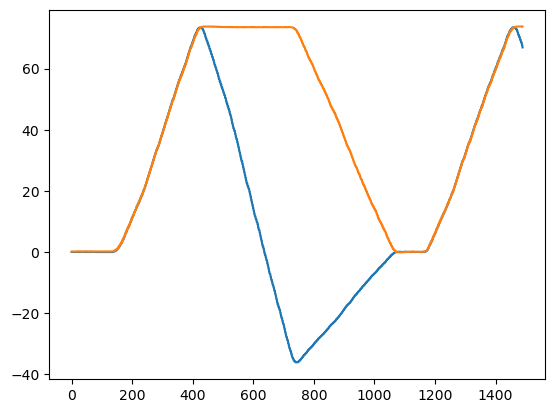

In [321]:
plt.plot(positions[:,0])
plt.plot(positions[:,1])

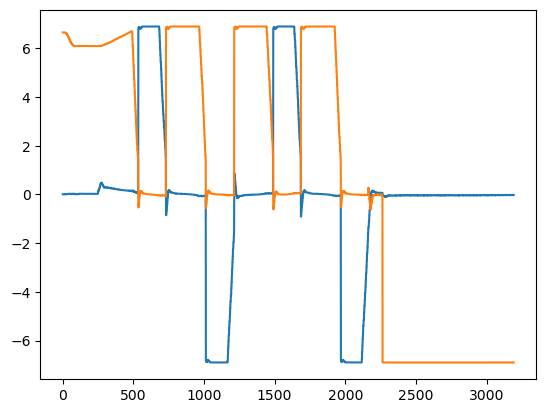

In [286]:
plt.plot(ref_vels[:,0])
plt.plot(ref_vels[:,1])

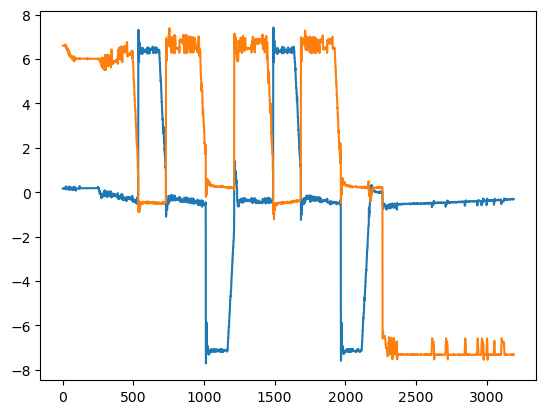

In [288]:
plt.plot(ref_vels[:,0] + actions[:,0])
plt.plot(ref_vels[:,1] + actions[:,1])

In [293]:
def save_results(filename):
    file_data, positions = process_file(filename)
    lstm = load_lstm()
    rl_agent = load_rl()
    actions, ref_vels = get_control_actions(lstm, rl_agent, file_data, positions)
    concatenated_array = np.concatenate((actions, ref_vels), axis=1)

    df = pd.DataFrame(concatenated_array, columns=['delta_vx', 'delta_vy', 'ref_vx', 'ref_vy', 'ref_vz'])
    df.to_csv('.' + filename.split('.')[1] + '_predictions.csv')

In [356]:
save_results('./data/luis_wind/e_shape_no_wind.pkl')

560263
3193


3193it [00:01, 2127.55it/s]


In [357]:
tmp = pd.read_csv('./data/luis_wind/e_shape_no_wind_predictions.csv')

In [360]:
tmp['ref_vx']

0       0.009511
1       0.009632
2       0.009706
3       0.009783
4       0.009868
          ...   
3188   -0.028566
3189   -0.028566
3190   -0.023405
3191   -0.023712
3192   -0.023289
Name: ref_vx, Length: 3193, dtype: float64

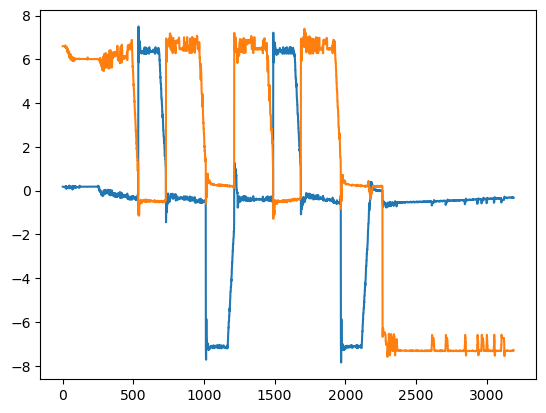

In [358]:
plt.plot(tmp['ref_vx'] + tmp['delta_vx'])
plt.plot(tmp['ref_vy'] + tmp['delta_vy'])